In [3]:
# Cell 1: Essential Imports
import os
import gc
import time
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

# TPU specific imports
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
from torch_xla.core import xla_model

import torch_xla.distributed.parallel_loader as pl # Still need this for ParallelLoader

# For EfficientNet models
import timm

# For plotting (optional, but good for visualizing results later)
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"torch_xla version: {torch_xla.__version__}")
print(f"timm version: {timm.__version__}")

/home/nurlanjalil/tpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
PyTorch version: 2.4.1+cu121
torch_xla version: 2.4.0
timm version: 1.0.17


In [4]:
# Cell 2: Configuration and Hyperparameters (MODIFIED for 2-Phase B0 Training)

# Dataset path
DATA_ROOT = '/home/nurlanjalil/trashnet_dataset' 

# Model parameters
# --- MODIFIED FOR EFFICIENTNET-B0 (2-Phase Training) ---
MODEL_NAME = 'efficientnet_b0' # Changed to b0 for this strategy
IMAGE_SIZE = 224 # Standard input size for EfficientNet-B0 is 224x224
NUM_CLASSES = 6

# Training parameters - Phase 1 (Frozen Base)
INITIAL_LR = 1e-3 # Higher LR for frozen base training
EPOCHS_FROZEN = 15 # Number of epochs for Phase 1

# Training parameters - Phase 2 (Unfrozen Base / Fine-tuning)
FINE_TUNE_LR = 1e-5 # Much lower LR for fine-tuning the full network
EPOCHS_FINE_TUNE = 35 # Number of epochs for Phase 2 (after frozen phase)
TOTAL_EPOCHS = EPOCHS_FROZEN + EPOCHS_FINE_TUNE # Total epochs will be 50

# General Training Parameter (Batch Size is consistent across phases)
BATCH_SIZE_PER_CORE = 32 # Keep at 32 for now, adjust if OOM occurs
TPU_NUM_CORES = xm.xrt_world_size()
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_CORE * TPU_NUM_CORES

# Data Split Ratios (No Change - Keeping 80/10/10)
TRAIN_SPLIT_RATIO = 0.80
VAL_SPLIT_RATIO   = 0.10
TEST_SPLIT_RATIO  = 0.10

# Environment settings (confirming float32 - No Change)
if 'XLA_USE_BF16' in os.environ:
    del os.environ['XLA_USE_BF16']
os.environ['XLA_USE_BF16'] = '0' 
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '1000000000'

print(f"--- Configuration Summary for 2-Phase Training ---")
print(f"Model Name: {MODEL_NAME}")
print(f"Image Input Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Phase 1 (Frozen): LR={INITIAL_LR}, Epochs={EPOCHS_FROZEN}")
print(f"Phase 2 (Fine-tune): LR={FINE_TUNE_LR}, Epochs={EPOCHS_FINE_TUNE}")
print(f"Total Epochs: {TOTAL_EPOCHS}")
print(f"Batch Size Per Core: {BATCH_SIZE_PER_CORE}")
print(f"Number of TPU Cores: {TPU_NUM_CORES}")
print(f"Global Batch Size: {GLOBAL_BATCH_SIZE}")
print(f"Data Split Ratios: Train {TRAIN_SPLIT_RATIO*100:.0f}% | Val {VAL_SPLIT_RATIO*100:.0f}% | Test {TEST_SPLIT_RATIO*100:.0f}%")
print(f"XLA BFloat16 Enabled (should be False): {os.environ.get('XLA_USE_BF16') == '1'}")
print("-------------------------------------------------")

--- Configuration Summary for 2-Phase Training ---
Model Name: efficientnet_b0
Image Input Size: 224x224
Number of Classes: 6
Phase 1 (Frozen): LR=0.001, Epochs=15
Phase 2 (Fine-tune): LR=1e-05, Epochs=35
Total Epochs: 50
Batch Size Per Core: 32
Number of TPU Cores: 1
Global Batch Size: 32
Data Split Ratios: Train 80% | Val 10% | Test 10%
XLA BFloat16 Enabled (should be False): False
-------------------------------------------------


In [6]:
# Cell 3: Data Transformations (Confirming float32 output)

# Define transformations for training data with augmentation
train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB') if isinstance(img, Image.Image) else Image.fromarray(img).convert('RGB')),
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), # This outputs torch.float32 (Default)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define transformations for validation/test data (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB') if isinstance(img, Image.Image) else Image.fromarray(img).convert('RGB')),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(), # This outputs torch.float32 (Default)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Data transformations defined. They should now output torch.float32.")

Data transformations defined. They should now output torch.float32.


In [7]:
# Cell 4: Dataset Loading and 3-Way Splitting (MODIFIED for 80/10/10 Split)

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=DATA_ROOT)

# Get class names (subfolder names) and map them to indices
class_names = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
print(f"Found {len(full_dataset)} images belonging to {len(class_names)} classes.")
print(f"Classes: {class_names}")
print(f"Class to index mapping: {class_to_idx}")

# Calculate sizes for each split based on the new ratios
total_size = len(full_dataset)
train_size = int(TRAIN_SPLIT_RATIO * total_size)
val_size   = int(VAL_SPLIT_RATIO * total_size)
test_size  = total_size - train_size - val_size # Ensure all images are accounted for

# Perform the 3-way split with fixed seed for reproducibility
g = torch.Generator().manual_seed(42)

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=g
)

# Helper class to apply specific transforms to a Subset (No Change)
class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

# Apply transformations to each subset
train_dataset = TransformedSubset(train_subset, train_transforms)
val_dataset = TransformedSubset(val_subset, val_test_transforms)
test_dataset = TransformedSubset(test_subset, val_test_transforms)


print(f"Training set size: {len(train_dataset)} images (approx {TRAIN_SPLIT_RATIO*100:.0f}%)")
print(f"Validation set size: {len(val_dataset)} images (approx {VAL_SPLIT_RATIO*100:.0f}%)")
print(f"Test set size: {len(test_dataset)} images (approx {TEST_SPLIT_RATIO*100:.0f}%)")
print("\nDataset split into Training, Validation, and Test sets, with transforms applied.")

Found 2527 images belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class to index mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Training set size: 2021 images (approx 80%)
Validation set size: 252 images (approx 10%)
Test set size: 254 images (approx 10%)

Dataset split into Training, Validation, and Test sets, with transforms applied.


In [8]:
# Cell 5: Model Definition

class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        # Load a pre-trained EfficientNet model from timm
        self.model = timm.create_model(model_name, pretrained=True)
        
        # Replace the classifier head for your specific number of classes
        # For EfficientNet models in timm, the final classification layer is usually 'classifier'.
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Function to create and return the model, with optional base model freezing
def create_model(model_name, num_classes, freeze_base=False):
    model = EfficientNetClassifier(model_name, num_classes)
    
    if freeze_base:
        # Freeze all parameters except the newly created 'classifier' head
        for name, param in model.named_parameters():
            if 'classifier' not in name: # This ensures only classifier parameters are trainable
                param.requires_grad = False
            else:
                param.requires_grad = True # Ensure the new classifier is trainable
        xm.master_print("Base model layers frozen. Only classifier head will be trained.")
    else:
        # By default, all parameters of a timm pre-trained model are trainable.
        xm.master_print("All model layers trainable (no freezing).")
    
    return model

print(f"Model creation function defined for {MODEL_NAME} with {NUM_CLASSES} output classes.")

Model creation function defined for efficientnet_b0 with 6 output classes.


In [6]:
# Cell 6: Training and Validation Functions (Core Logic - Confirming float32 batch handling)

# Helper class to average metrics across processes (from the PyTorch/XLA tutorial)
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training function for a single epoch on a single TPU core
def train_loop_fn(loader, model, criterion, optimizer, device, epoch):
    model.train()
    tracker = AverageMeter()
    
    para_loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    xm.master_print(f"Epoch {epoch}: Training on device {xm.get_ordinal()}/{xm.xrt_world_size()}...")
    
    for batch_idx, (data, target) in enumerate(para_loader):
        
        optimizer.zero_grad()
        
        # DIAGNOSTIC PRINT: Check input data type right before model call
        if batch_idx == 0 and xm.get_ordinal() == 0:
            xm.master_print(f"DEBUG: Input data dtype before model: {data.dtype}")
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        xm.optimizer_step(optimizer)

        tracker.update(loss.item(), data.size(0))

        if batch_idx % 10 == 0:
            xm.master_print(f"Epoch {epoch} | Ordinal {xm.get_ordinal()}: Batch {batch_idx}/{len(loader)} | Current Loss: {loss.item():.4f} | Avg Loss: {tracker.avg:.4f}")
        
    xm.master_print(f"Epoch {epoch}: Ordinal {xm.get_ordinal()} - Average Train Loss: {tracker.avg:.4f}")
    return tracker.avg

# Validation function for a single epoch on a single TPU core
def val_loop_fn(loader, model, criterion, device):
    model.eval()
    tracker = AverageMeter()
    
    para_loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    xm.master_print(f"Validation on device {xm.get_ordinal()}/{xm.xrt_world_size()}...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(para_loader):
            # --- CRITICAL MODIFICATION: REMOVE BFLOAT16 CONVERSION HERE ---
            # data = data.to(torch.bfloat16) # This line should be commented out or removed
            # --- End CRITICAL MODIFICATION ---
            output = model(data)
            loss = criterion(output, target)
            
            tracker.update(loss.item(), data.size(0))
            
    xm.master_print(f"Ordinal {xm.get_ordinal()} - Average Validation Loss: {tracker.avg:.4f}")
    return tracker.avg

In [7]:
# Cell 7: The Multi-Processing Wrapper Function (_mp_fn - CRITICAL MODIFICATION for 2-Phase Strategy)

def _mp_fn(rank, flags):
    torch.set_default_dtype(torch.float32)
    device = xm.xla_device()

    # --- Phase 1: Feature Extraction (Frozen Base) ---
    xm.master_print("\n--- Phase 1: Feature Extraction (Frozen Base) ---")
    model = create_model(flags['model_name'], flags['num_classes'], freeze_base=True)
    model = model.to(device).to(torch.float32)

    optimizer_phase1 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=flags['initial_lr'])
    criterion = nn.CrossEntropyLoss()

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
    val_sampler = torch.utils.data.distributed.DistributedSampler(
        val_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
    train_loader = DataLoader(
        train_dataset, batch_size=flags['batch_size_per_core'], sampler=train_sampler, num_workers=0, drop_last=True)
    val_loader = DataLoader(
        val_dataset, batch_size=flags['batch_size_per_core'], sampler=val_sampler, num_workers=0, drop_last=True)

    # Placeholders for metrics history for the entire training run
    history = {'train_loss': [], 'val_loss': [], 'epoch_time': []}
    best_val_loss = float('inf')

    # EarlyStopping monitoring for Phase 1
    patience_phase1 = 5 # Stop if val_loss doesn't improve for 5 epochs
    epochs_no_improve_phase1 = 0 
    
    for epoch in range(1, flags['epochs_frozen'] + 1):
        epoch_start_time = time.time()
        train_loader.sampler.set_epoch(epoch)

        train_loss = train_loop_fn(train_loader, model, criterion, optimizer_phase1, device, epoch)
        val_loss = val_loop_fn(val_loader, model, criterion, device)
        
        global_train_loss = xm.all_reduce(reduce_type='sum', inputs=torch.tensor(train_loss, device=device)) / xm.xrt_world_size()
        global_val_loss = xm.all_reduce(reduce_type='sum', inputs=torch.tensor(val_loss, device=device)) / xm.xrt_world_size()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        history['train_loss'].append(global_train_loss.item())
        history['val_loss'].append(global_val_loss.item())
        history['epoch_time'].append(epoch_duration)

        xm.master_print(f"--- Phase 1 Epoch {epoch}/{flags['epochs_frozen']} Summary ---")
        xm.master_print(f"Global Train Loss: {global_train_loss.item():.4f} | Global Val Loss: {global_val_loss.item():.4f}")
        xm.master_print(f"Epoch Duration: {epoch_duration:.2f} seconds")

        # EarlyStopping logic for Phase 1
        if global_val_loss.item() < best_val_loss:
            best_val_loss = global_val_loss.item()
            epochs_no_improve_phase1 = 0
            # Save best model even in Phase 1
            model_save_path = f'best_model_{flags["model_name"]}_frozen_phase.pt'
            xm.save(model.state_dict(), model_save_path)
            xm.master_print(f"Saved best model for frozen phase to {model_save_path} with val loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve_phase1 += 1
            xm.master_print(f"Validation loss did not improve. Patience: {epochs_no_improve_phase1}/{patience_phase1}")

        xm.mark_step() # Marks the end of a computation step

        if epochs_no_improve_phase1 >= patience_phase1:
            xm.master_print(f"Early stopping triggered in Phase 1 after {epoch} epochs.")
            break # Exit the Phase 1 loop

    # --- Phase 2: Fine-Tuning (Unfreeze All Layers) ---
    xm.master_print("\n--- Phase 2: Fine-Tuning (Unfreeze All Layers) ---")

    # If early stopping triggered, restore best weights from frozen phase
    if epochs_no_improve_phase1 >= patience_phase1:
        xm.master_print("Restoring best weights from frozen phase for fine-tuning...")
        model_save_path_frozen = f'best_model_{flags["model_name"]}_frozen_phase.pt'
        # Load state dict (from master core)
        if xm.get_ordinal() == 0:
            model.load_state_dict(torch.load(model_save_path_frozen, map_location=torch.device('cpu')))
        xm.rendezvous('load_model_state_dict') # Barrier to ensure all cores load
        model.to(device).to(torch.float32) # Re-move to device and ensure dtype

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    
    # Re-initialize optimizer with new learning rate for fine-tuning
    optimizer_phase2 = optim.Adam(model.parameters(), lr=flags['fine_tune_lr'])
    # ReduceLROnPlateau scheduler for fine-tuning phase
    scheduler_phase2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_phase2, mode='min', factor=0.5, patience=3, verbose=True)

    # Reset early stopping for Phase 2
    patience_phase2 = 7 # Higher patience for fine-tuning
    epochs_no_improve_phase2 = 0
    # Continue best_val_loss from Phase 1
    
    start_epoch_phase2 = history['epoch_time'].__len__() + 1 # Continue epoch numbering

    for epoch in range(start_epoch_phase2, flags['total_epochs'] + 1):
        epoch_start_time = time.time()
        train_loader.sampler.set_epoch(epoch) # Update sampler for continuous epoch numbering

        train_loss = train_loop_fn(train_loader, model, criterion, optimizer_phase2, device, epoch)
        val_loss = val_loop_fn(val_loader, model, criterion, device)
        
        global_train_loss = xm.all_reduce(reduce_type='sum', inputs=torch.tensor(train_loss, device=device)) / xm.xrt_world_size()
        global_val_loss = xm.all_reduce(reduce_type='sum', inputs=torch.tensor(val_loss, device=device)) / xm.xrt_world_size()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        history['train_loss'].append(global_train_loss.item())
        history['val_loss'].append(global_val_loss.item())
        history['epoch_time'].append(epoch_duration)

        xm.master_print(f"--- Phase 2 Epoch {epoch}/{flags['total_epochs']} Summary ---")
        xm.master_print(f"Global Train Loss: {global_train_loss.item():.4f} | Global Val Loss: {global_val_loss.item():.4f}")
        xm.master_print(f"Epoch Duration: {epoch_duration:.2f} seconds")

        # Scheduler step using validation loss
        scheduler_phase2.step(global_val_loss.item())

        # EarlyStopping logic for Phase 2
        if global_val_loss.item() < best_val_loss:
            best_val_loss = global_val_loss.item()
            epochs_no_improve_phase2 = 0
            # Save best model for overall training
            model_save_path = f'best_model_{flags["model_name"]}_final.pt'
            xm.save(model.state_dict(), model_save_path)
            xm.master_print(f"Saved best overall model to {model_save_path} with val loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve_phase2 += 1
            xm.master_print(f"Validation loss did not improve. Patience: {epochs_no_improve_phase2}/{patience_phase2}")

        xm.mark_step() # Marks the end of a computation step

        if epochs_no_improve_phase2 >= patience_phase2:
            xm.master_print(f"Early stopping triggered in Phase 2 after {epoch} epochs.")
            break # Exit the Phase 2 loop
    
    xm.master_print("Total Training complete!")

    # Save final history data (only from the master core)
    if xm.get_ordinal() == 0:
        np.save(f'train_losses_{flags["model_name"]}.npy', np.array(history['train_loss']))
        np.save(f'val_losses_{flags["model_name"]}.npy', np.array(history['val_loss']))
        np.save(f'epoch_times_{flags["model_name"]}.npy', np.array(history['epoch_time']))
        xm.master_print(f"Loss and epoch time history saved to VM disk with {flags['model_name']} prefix.")

    del model, optimizer_phase1, optimizer_phase2, criterion, train_loader, val_loader, scheduler_phase2
    gc.collect()

In [ ]:
# Cell 8: Launch Training!

# Define a dictionary to pass all necessary flags (hyperparameters) to _mp_fn
flags = {
    'initial_lr': INITIAL_LR,
    'fine_tune_lr': FINE_TUNE_LR,
    'epochs_frozen': EPOCHS_FROZEN,
    'epochs_fine_tune': EPOCHS_FINE_TUNE, # Although _mp_fn uses total_epochs implicitly, this is for clarity
    'total_epochs': TOTAL_EPOCHS,

    'batch_size_per_core': BATCH_SIZE_PER_CORE,
    'model_name': MODEL_NAME,
    'num_classes': NUM_CLASSES,
}

print("Initiating training process on TPU...")
xmp.spawn(_mp_fn, args=(flags,), nprocs=TPU_NUM_CORES, start_method='fork')

print("\nTraining process initiated. Monitor the output above for real-time progress and logs from the TPU cores.")
print("If the training completes, check the files saved on your VM's home directory.")

In [10]:
# Cell 9: Test Set Evaluation (Run AFTER training in Cell 8 finishes successfully)

print("--- Starting Final Evaluation on the Test Set ---")

# Define the model class 
class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False) # No need for pretrained weights here
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model and load state dict from the saved best model
model_path = f'/home/nurlanjalil/best_model_{MODEL_NAME}_final.pt'
loaded_model = EfficientNetClassifier(MODEL_NAME, NUM_CLASSES)

# Load to CPU for evaluation. map_location ensures it loads correctly regardless of device.
# Cast the model to float32, as it was trained in float32.
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
loaded_model.to(torch.float32) # Cast to float32 for evaluation
loaded_model.eval() # Set to evaluation mode (disables dropout, batchnorm updates)

print(f"Loaded best model from: {model_path}")

# Create a DataLoader for the test set
# For single-process inference, no DistributedSampler or ParallelLoader needed.
# Use a large batch size if memory permits for faster inference.
test_loader = DataLoader(
    test_dataset,
    batch_size=GLOBAL_BATCH_SIZE, # Can use global batch size or smaller for inference
    shuffle=False, # Do NOT shuffle test data
    num_workers=2, # Use CPU workers for data loading (adjust based on VM CPU cores)
    pin_memory=True
)

# Use CPU as evaluation device for simplicity, or set to 'cuda' if running on a GPU machine
eval_device = torch.device("cpu")
loaded_model.to(eval_device)

# Evaluation loop
correct_predictions = 0
total_predictions = 0
test_loss_meter = AverageMeter() # Re-use the AverageMeter class

criterion = nn.CrossEntropyLoss() # Use the same loss function as training

# Using xm.master_print for consistency, but this block runs on CPU only.
xm.master_print("Starting final evaluation on the Test Set...")

with torch.no_grad(): # Disable gradient calculations
    for i, (data, target) in enumerate(test_loader):
        # Move data to evaluation device (CPU)
        data, target = data.to(eval_device), target.to(eval_device)
        
        outputs = loaded_model(data)
        loss = criterion(outputs, target)
        test_loss_meter.update(loss.item(), data.size(0))

        _, predicted = torch.max(outputs.data, 1) # Get the predicted class index
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        if i % 10 == 0: # Print less frequently for test set
            xm.master_print(f"Test Batch {i}/{len(test_loader)} | Loss: {test_loss_meter.avg:.4f}")
            
test_accuracy = correct_predictions / total_predictions
xm.master_print("--- Test Set Evaluation Complete ---")
xm.master_print(f"Final Test Loss: {test_loss_meter.avg:.4f}")
xm.master_print(f"Final Test Accuracy: {test_accuracy:.4f}")

--- Starting Final Evaluation on the Test Set ---
Loaded best model from: /home/nurlanjalil/best_model_efficientnet_b0_final.pt
Starting final evaluation on the Test Set...


/tmp/ipykernel_84747/2132222357.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Test Batch 0/8 | Loss: 0.3710
--- Test Set Evaluation Complete ---
Final Test Loss: 0.3208
Final Test Accuracy: 0.8937


--- Plotting Training Metrics ---


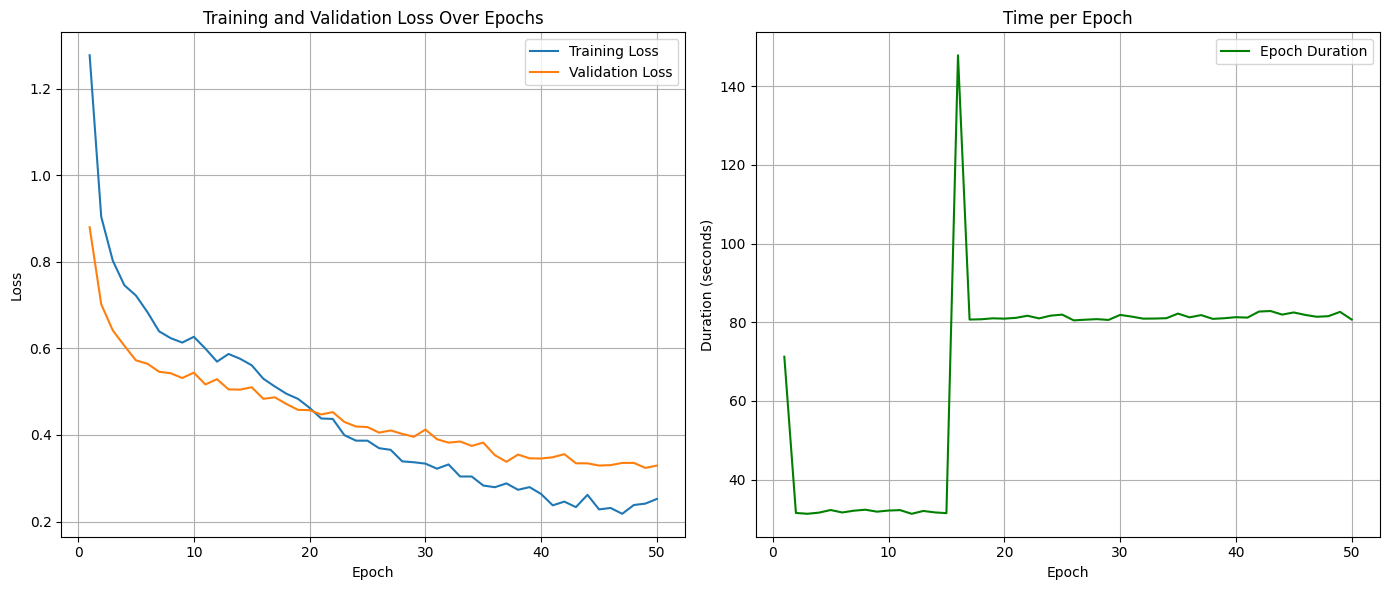

Training metrics plot generated and saved as 'training_metrics_plot_efficientnet_b0.png'.


In [12]:
# Cell 10: Plotting Loss and Time History (Run AFTER training and evaluation)

print("--- Plotting Training Metrics ---")

try:
    # Load the history data saved by the master core
    train_losses = np.load(f'/home/nurlanjalil/train_losses_{MODEL_NAME}.npy')
    val_losses = np.load(f'/home/nurlanjalil/val_losses_{MODEL_NAME}.npy')
    epoch_times = np.load(f'/home/nurlanjalil/epoch_times_{MODEL_NAME}.npy')

    # Plot the losses
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot the time per epoch
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.plot(range(1, len(epoch_times) + 1), epoch_times, label='Epoch Duration', color='green')
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Duration (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to VM disk (you can then download it via gcloud scp)
    plot_save_path = f'training_metrics_plot_{MODEL_NAME}.png' # Also update save name
    plt.savefig(plot_save_path)
    plt.show()

    print(f"Training metrics plot generated and saved as '{plot_save_path}'.")

except FileNotFoundError:
    print("Loss history files not found. Ensure training completed successfully and paths are correct.")
    print(f"Expected files: train_losses_{MODEL_NAME}.npy, val_losses_{MODEL_NAME}.npy, epoch_times_{MODEL_NAME}.npy")
except Exception as e:
    print(f"An error occurred while plotting: {e}")

--- Starting Single Image Prediction ---


/tmp/ipykernel_113302/72071121.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Model 'efficientnet_b0' loaded successfully from /home/nurlanjalil/best_model_efficientnet_b0_final.pt
Loading image from: /home/nurlanjalil/real-test-images/sirabbutulka.jpg

--- Prediction Results ---
Predicted Class: plastic
Confidence: 0.9978


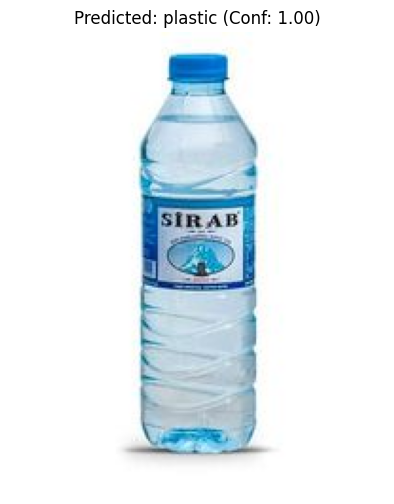


--- Raw Probabilities ---
cardboard: 0.0009
glass: 0.0004
metal: 0.0001
paper: 0.0000
plastic: 0.9978
trash: 0.0008

--- Single Image Prediction Complete ---


In [10]:
# Cell 11: Single Image Prediction (MODIFIED for Local Path)

import matplotlib.pyplot as plt # For displaying the image

print("--- Starting Single Image Prediction ---")

# Initialize model and load state dict from the best overall model
# Make sure MODEL_NAME and NUM_CLASSES are defined (from Cell 2)
model_path = f'/home/nurlanjalil/best_model_{MODEL_NAME}_final.pt'
loaded_model = EfficientNetClassifier(MODEL_NAME, NUM_CLASSES)
loaded_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
loaded_model.to(torch.float32) # Model was trained in float32
loaded_model.eval() # Set to evaluation mode

print(f"Model '{MODEL_NAME}' loaded successfully from {model_path}")

# Get local image path from user input
image_local_path = '/home/nurlanjalil/real-test-images/sirabbottle.jpg'

try:
    # 1. Open the image from local path
    xm.master_print(f"Loading image from: {image_local_path}")
    img = Image.open(image_local_path).convert('RGB') # Use PIL to open the image
    
    # 2. Preprocess the image
    # Apply the same transformations used for validation/test data
    # Ensure val_test_transforms is defined in Cell 3 and executed
    input_tensor = val_test_transforms(img)
    input_batch = input_tensor.unsqueeze(0) # Add a batch dimension

    # 3. Perform inference
    with torch.no_grad():
        output = loaded_model(input_batch)
    
    # Get probabilities (softmax for classification)
    probabilities = torch.softmax(output, dim=1)
    
    # Get predicted class
    predicted_prob, predicted_idx = torch.max(probabilities, 1)
    predicted_class_name = class_names[predicted_idx.item()]

    # 4. Display results
    print("\n--- Prediction Results ---")
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Confidence: {predicted_prob.item():.4f}")

    # Optional: Display the image and its prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name} (Conf: {predicted_prob.item():.2f})")
    plt.axis('off')
    plt.show()

    print("\n--- Raw Probabilities ---")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probabilities[0, i].item():.4f}")

except FileNotFoundError:
    print(f"Error: Image file not found at '{image_local_path}'. Please check the path.")
except Exception as e:
    print(f"An error occurred during prediction: {e}")
    print("Please ensure the path is correct and the file is a valid image.")

print("\n--- Single Image Prediction Complete ---")